In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from data import Darcys_Dataset
from unet2d_spatial import Unet2D_Spatial
from diffuser import GaussianDiffusion

In [2]:
ds = Darcys_Dataset('../data/darcy_data_r241_N200.mat')

Loaded 200 samples from ../data/darcy_data_r241_N200.mat
Shape of x: torch.Size([200, 1, 240, 240])


In [3]:
model = Unet2D_Spatial(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 240, 240),
    timesteps=800,
    objective='pred_x0',
    physics_loss_weight=0.0
).to("cuda:1")

In [4]:
x = ds[:8]['x']
y = ds[:8]['y']

In [6]:
def make_prediction(diffuser, cond, physics_loss_weight):
    diffuser.model.load_state_dict(torch.load(f"./ckpts/darcy_{physics_loss_weight:.2f}phyloss/ckpt_clean.pt"))
    x_pred = diffuser.sample(cond)

    return x_pred.cpu().numpy().squeeze()

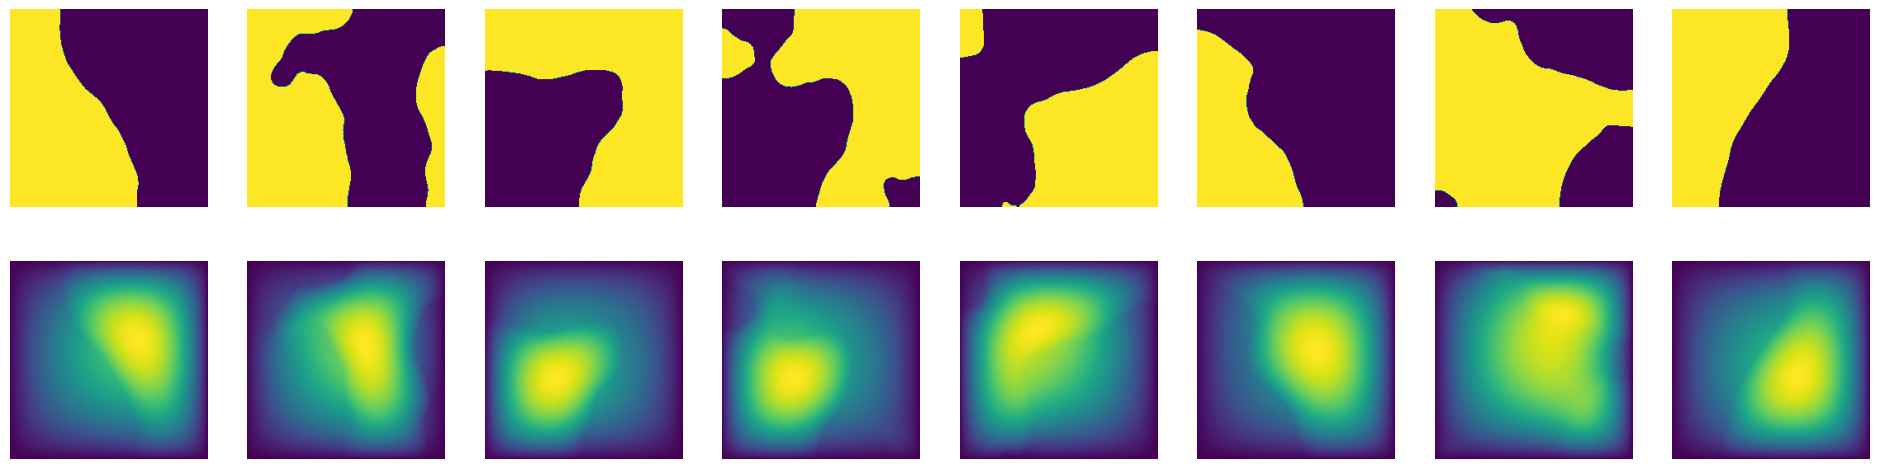

In [7]:
fig, ax = plt.subplots(2, 8, figsize=(24, 6))
for i in range(8):
    ax[0, i].imshow(x[i, 0, :, :])
    ax[0, i].set_axis_off()
    ax[1, i].imshow(y[i, 0, :, :])
    ax[1, i].set_axis_off()

In [8]:
x_pred000 = make_prediction(diffusion_model, y, 0.00)
# x_pred005 = make_prediction(diffusion_model, y, 0.05)
# x_pred010 = make_prediction(diffusion_model, y, 0.10)
# x_pred020 = make_prediction(diffusion_model, y, 0.20)


DDPM sampling: 100%|██████████| 800/800 [01:36<00:00,  8.25it/s]


In [9]:
x_span = np.linspace(0, 1, 240)
y_span = np.linspace(0, 1, 240)
X, Y = np.meshgrid(x_span, y_span)

In [10]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

In [11]:
def unnormalize(x, x_max=12, x_min=3):
    x_clip = np.clip(x, 0, 1)
    return (x_max - x_min) * x_clip + x_min

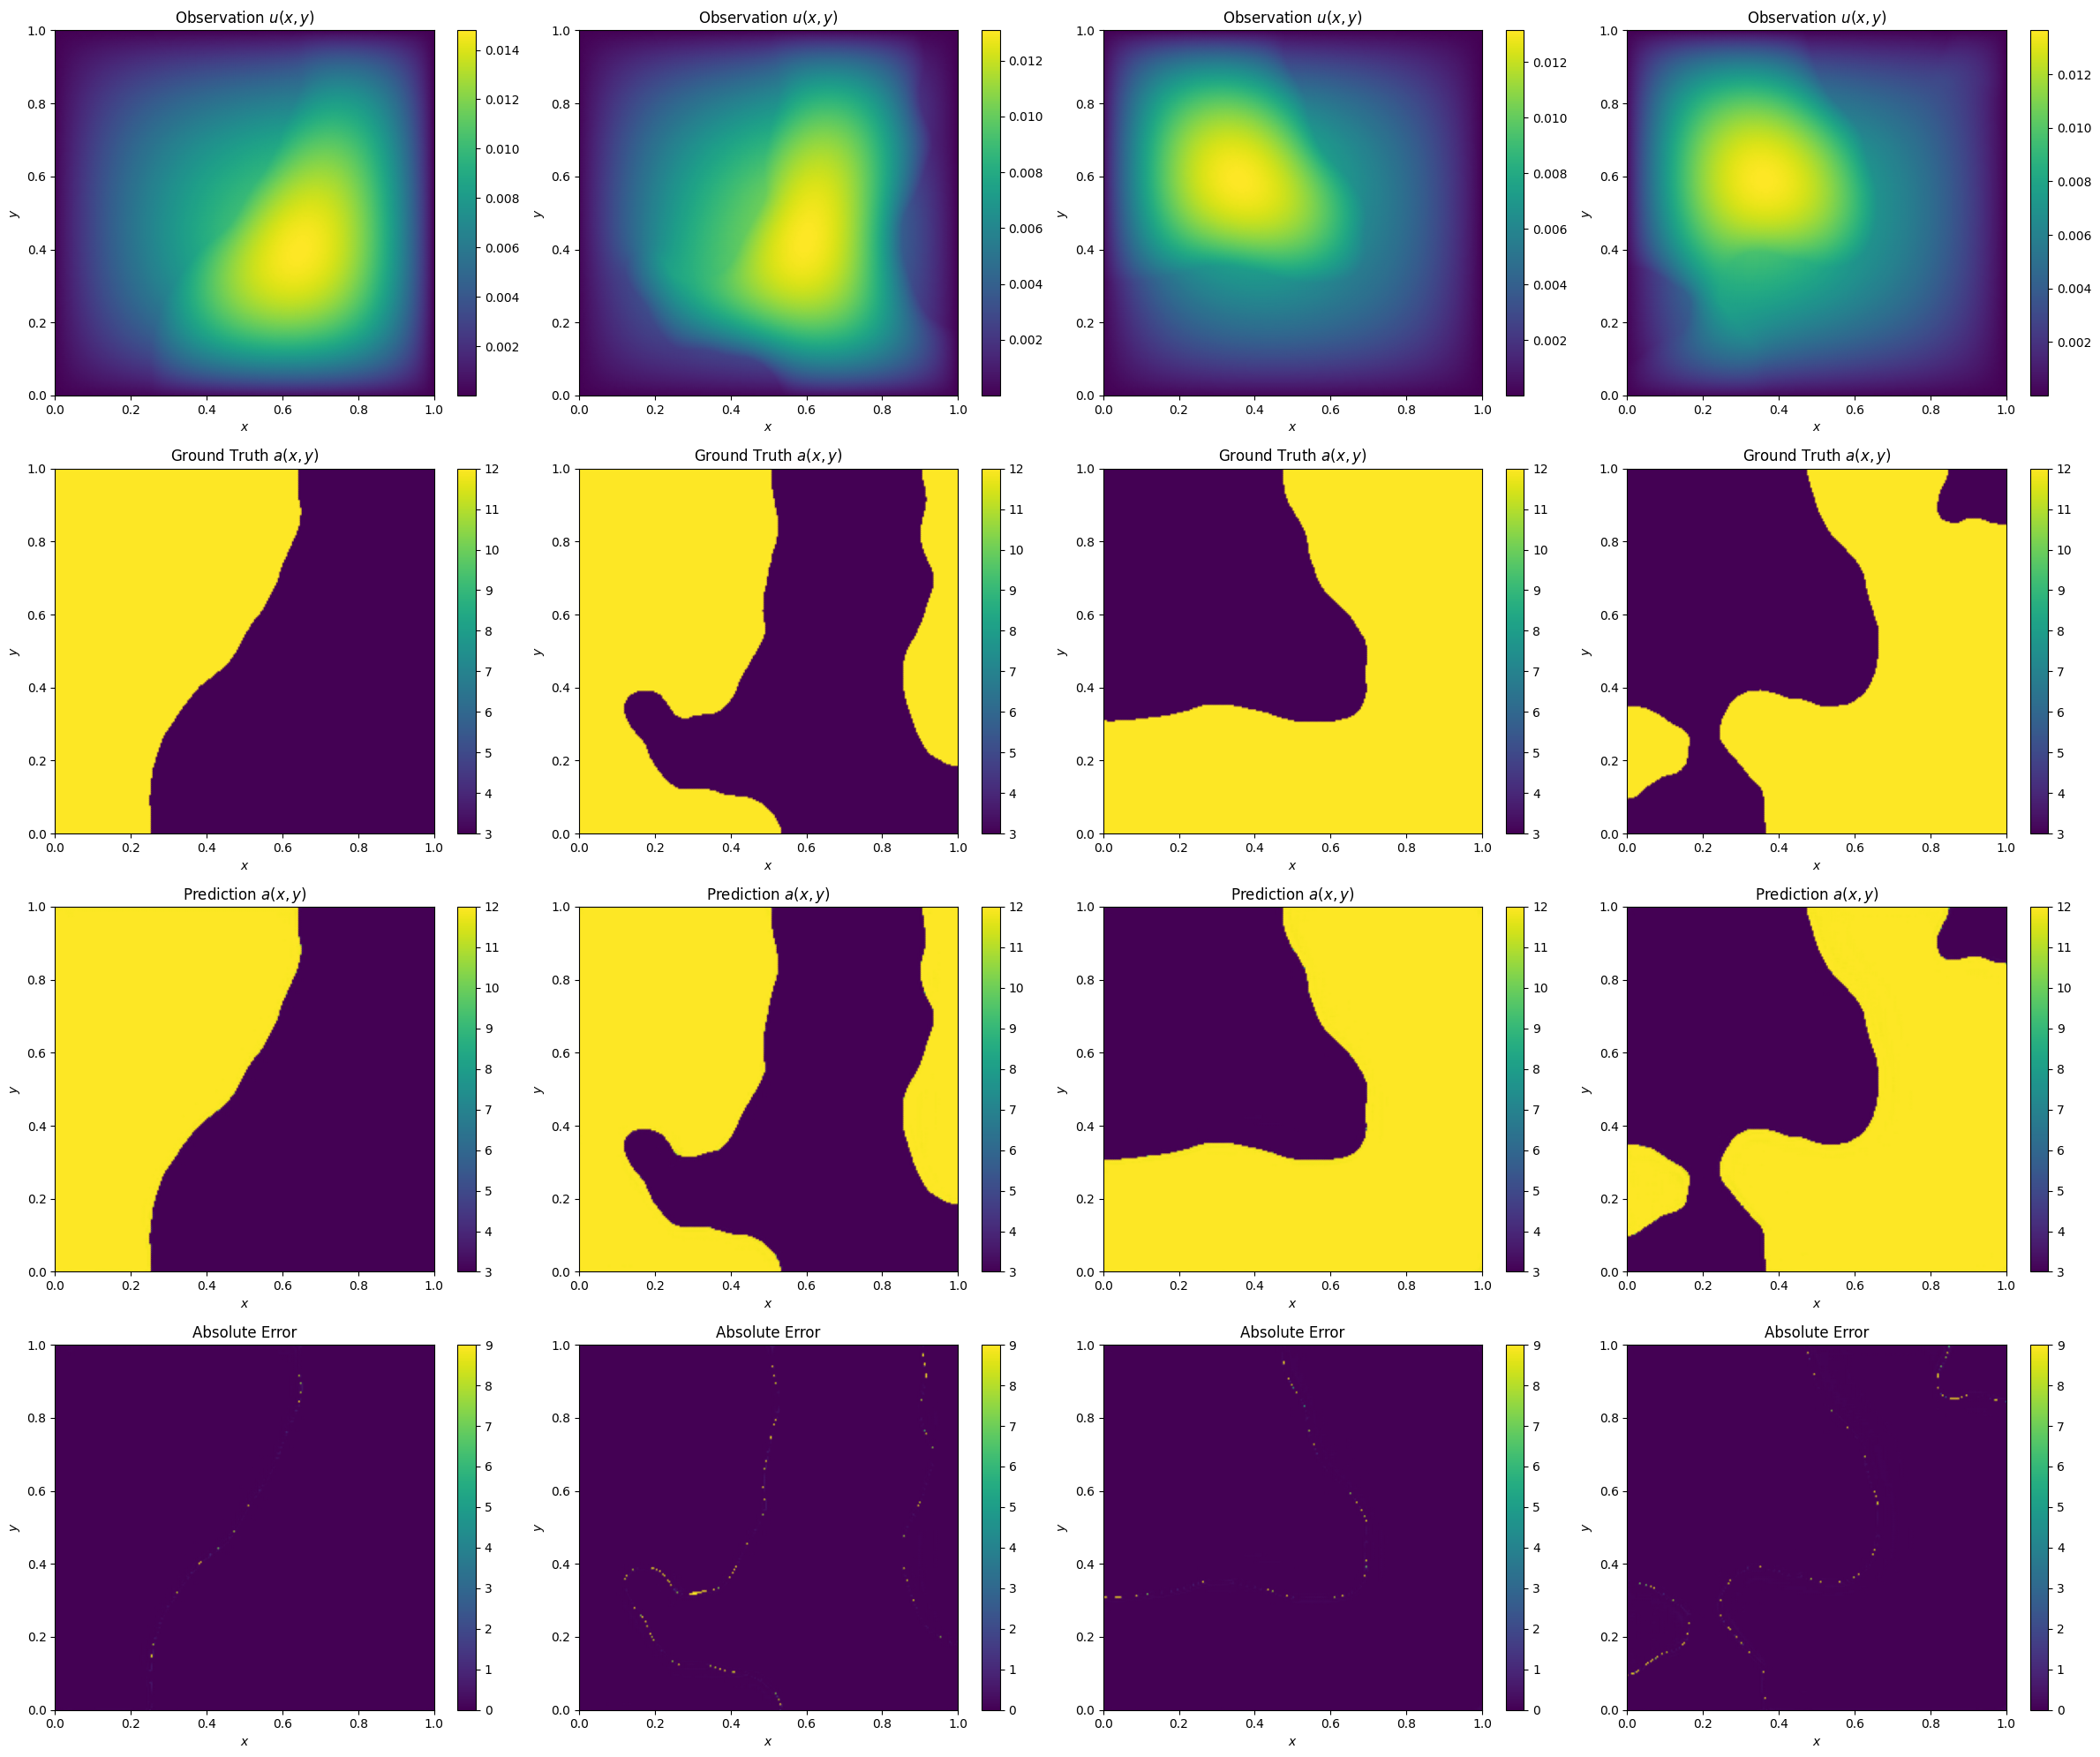

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(24, 20))
for i in range(4):
    im1 = ax[0, i].pcolormesh(X, Y, y[i], shading='gouraud')
    ax[0, i].set_xlabel('$x$')
    ax[0, i].set_ylabel('$y$')
    ax[0, i].set_title('Observation $u(x, y)$')
    # ax[i, 1].set_axis('square')
    fig.colorbar(im1, ax=ax[0, i])
    plt.tight_layout()

    im2 = ax[1, i].pcolormesh(X, Y, unnormalize(x[i]), shading='gouraud')
    ax[1, i].set_xlabel('$x$')
    ax[1, i].set_ylabel('$y$')
    ax[1, i].set_title('Ground Truth $a(x, y)$')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im2, ax=ax[1, i])
    plt.tight_layout()

    im3 = ax[2, i].pcolormesh(X, Y, unnormalize(x_pred000[i]), shading='gouraud')
    ax[2, i].set_xlabel('$x$')
    ax[2, i].set_ylabel('$y$')
    ax[2, i].set_title('Prediction $a(x, y)$')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im3, ax=ax[2, i])
    plt.tight_layout()

    im4 = ax[3, i].pcolormesh(X, Y, np.abs(unnormalize(x_pred000[i])-unnormalize(x[i])), shading='gouraud')
    ax[3, i].set_xlabel('$x$')
    ax[3, i].set_ylabel('$y$')
    ax[3, i].set_title('Absolute Error')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im4, ax=ax[3, i])
    plt.tight_layout()

In [21]:
fig.savefig('../assets/darcy_exp1.png')

In [50]:
def cal_mis_classification_rate(x, x_pred, x_max=12, x_min=3):
    b_size = x.shape[0]
    x = unnormalize(x, x_max, x_min)
    x_pred = unnormalize(x_pred, x_max, x_min)
    return np.sum(np.abs(x-x_pred) > 0.5) / (240*240*b_size)

In [51]:
mcr000 = cal_mis_classification_rate(x, x_pred000)
mcr005 = cal_mis_classification_rate(x, x_pred005)
mcr010 = cal_mis_classification_rate(x, x_pred010)
mcr020 = cal_mis_classification_rate(x, x_pred020)

In [53]:
print(f"Misclassification rate for 0.00 physics loss: {mcr000:.2%}")
print(f"Misclassification rate for 0.05 physics loss: {mcr005:.2%}")
print(f"Misclassification rate for 0.10 physics loss: {mcr010:.2%}")
print(f"Misclassification rate for 0.20 physics loss: {mcr020:.2%}")

Misclassification rate for 0.00 physics loss: 0.14%
Misclassification rate for 0.05 physics loss: 5.80%
Misclassification rate for 0.10 physics loss: 9.34%
Misclassification rate for 0.20 physics loss: 14.02%


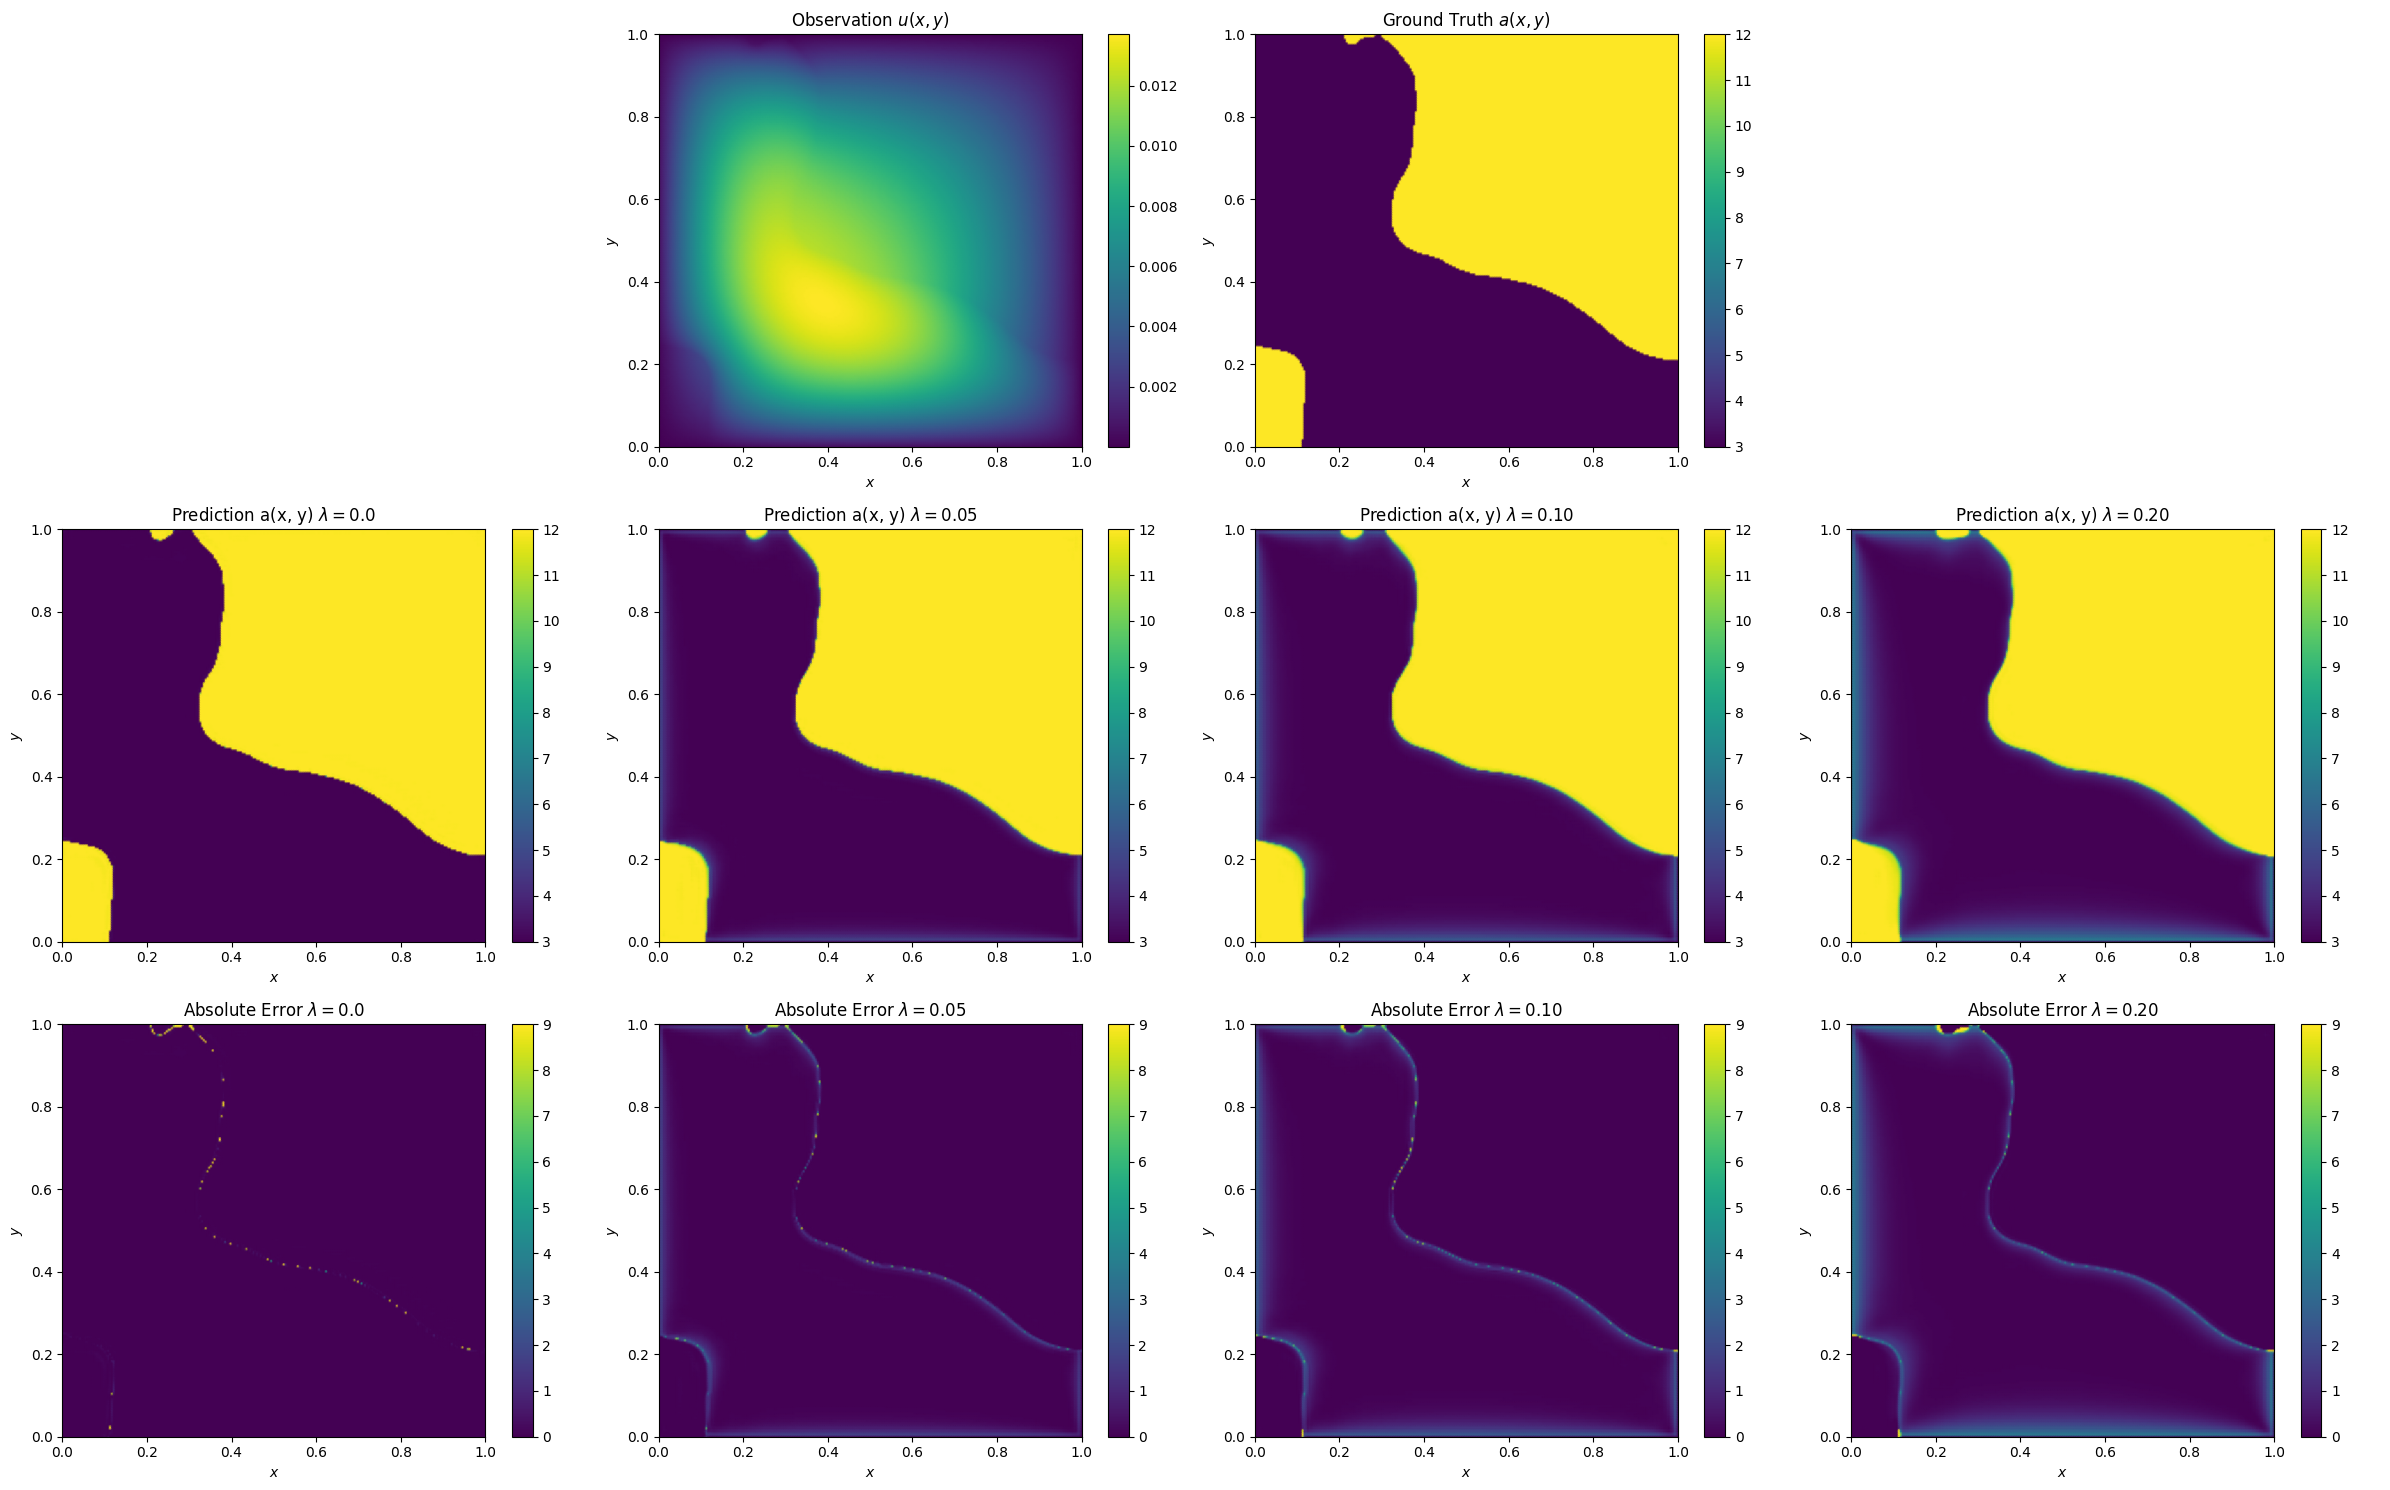

In [46]:
n = 4
fig, ax = plt.subplots(3, 4, figsize=(24, 15))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].pcolormesh(X, Y, y[n], shading='gouraud')
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$y$')
ax[0, 1].set_title('Observation $u(x, y)$')
fig.colorbar(im1, ax=ax[0, 1])
plt.tight_layout()

im2 = ax[0, 2].pcolormesh(X, Y, unnormalize(x[n]), shading='gouraud')
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$y$')
ax[0, 2].set_title('Ground Truth $a(x, y)$')
fig.colorbar(im2, ax=ax[0, 2])
plt.tight_layout()

im3 = ax[1, 0].pcolormesh(X, Y, unnormalize(x_pred000[n]), shading='gouraud')
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$y$')
ax[1, 0].set_title(r'Prediction a(x, y) $\lambda=0.0$')
fig.colorbar(im3, ax=ax[1, 0])
plt.tight_layout()

im4 = ax[1, 1].pcolormesh(X, Y, unnormalize(x_pred005[n]), shading='gouraud')
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$y$')
ax[1, 1].set_title(r'Prediction a(x, y) $\lambda=0.05$')
fig.colorbar(im4, ax=ax[1, 1])
plt.tight_layout()

im5 = ax[1, 2].pcolormesh(X, Y, unnormalize(x_pred010[n]), shading='gouraud')
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$y$')
ax[1, 2].set_title(r'Prediction a(x, y) $\lambda=0.10$')
fig.colorbar(im5, ax=ax[1, 2])
plt.tight_layout()

im6 = ax[1, 3].pcolormesh(X, Y, unnormalize(x_pred020[n]), shading='gouraud')
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$y$')
ax[1, 3].set_title(r'Prediction a(x, y) $\lambda=0.20$')
fig.colorbar(im6, ax=ax[1, 3])
plt.tight_layout()

im7 = ax[2, 0].pcolormesh(X, Y, np.abs(unnormalize(x_pred000[n])-unnormalize(x[n])), shading='gouraud')
ax[2, 0].set_xlabel('$x$')
ax[2, 0].set_ylabel('$y$')
ax[2, 0].set_title(r'Absolute Error $\lambda=0.0$')
fig.colorbar(im7, ax=ax[2, 0])
plt.tight_layout()

im8 = ax[2, 1].pcolormesh(X, Y, np.abs(unnormalize(x_pred005[n])-unnormalize(x[n])), shading='gouraud')
ax[2, 1].set_xlabel('$x$')
ax[2, 1].set_ylabel('$y$')
ax[2, 1].set_title(r'Absolute Error $\lambda=0.05$')
fig.colorbar(im8, ax=ax[2, 1])
plt.tight_layout()

im9 = ax[2, 2].pcolormesh(X, Y, np.abs(unnormalize(x_pred010[n])-unnormalize(x[n])), shading='gouraud')
ax[2, 2].set_xlabel('$x$')
ax[2, 2].set_ylabel('$y$')
ax[2, 2].set_title(r'Absolute Error $\lambda=0.10$')
fig.colorbar(im9, ax=ax[2, 2])
plt.tight_layout()

im10 = ax[2, 3].pcolormesh(X, Y, np.abs(unnormalize(x_pred020[n])-unnormalize(x[n])), shading='gouraud')
ax[2, 3].set_xlabel('$x$')
ax[2, 3].set_ylabel('$y$')
ax[2, 3].set_title(r'Absolute Error $\lambda=0.20$')
fig.colorbar(im10, ax=ax[2, 3])
plt.tight_layout()

In [54]:
fig.savefig('../assets/darcy_exp2.png', bbox_inches='tight')